In [2]:
import numpy as np
from scipy import stats 
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker

In [3]:
engine = create_engine("postgresql:///music")
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

In [4]:
# Space for NB Explanation

In [5]:
# First HYP  111111111

In [6]:
# Find mu of review scores
query = """
    SELECT score
    FROM reviews
"""
result = con.execute(query).fetchall()
scores_all_labels = np.array(result)

In [7]:
print(scores_all_labels[0])
print(scores_all_labels[0][0])

[9.3]
9.3


In [8]:
# The scores are nested, lets slice by index to extract them.
scores_all_labels = scores_all_labels[:,0]

In [9]:
scores_all_labels[0]

9.3

In [10]:
mu_review_score = scores_all_labels.mean()
mu_review_score

7.005779372587398

In [11]:
#Retreive and array of scores for self-released albums
query = """
    SELECT score
    FROM reviews
    JOIN labels
    USING(reviewid)
    WHERE label = 'self-released'
    """
result = con.execute(query).fetchall()
scores_self_released = np.array(result)[:,0]

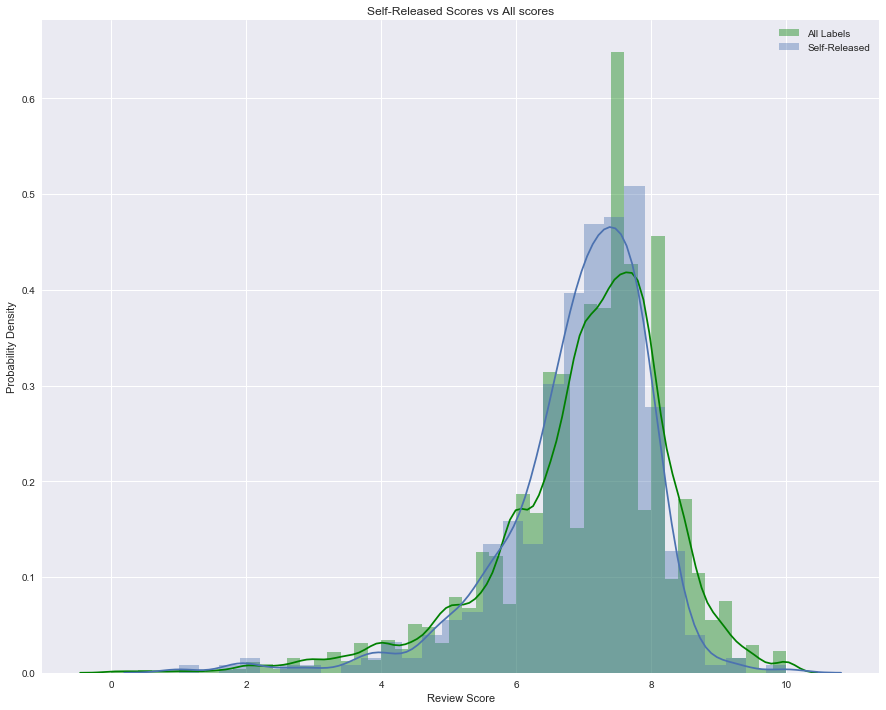

In [12]:
plt.figure(figsize=(15,12))
plt.style.use('seaborn')
sns.distplot(scores_all_labels, color='green', label='All Labels')
sns.distplot(scores_self_released, label='Self-Released');
plt.ylabel('Probability Density')
plt.xlabel('Review Score')
plt.title('Self-Released Scores vs All scores')
plt.legend();

In [13]:
alpha = 0.025

t_val, p_val = stats.ttest_1samp(scores_self_released, mu_review_score)

df = len(scores_self_released)-1
t_crit = stats.t.ppf(alpha, df)

print(f"""
    t_val: {t_val}
    t_crit: {t_crit}
    p_val: {p_val}
    alpha: {alpha}
    """)


    t_val: -1.6196902904798227
    t_crit: -1.9656418415415793
    p_val: 0.10605118857851459
    alpha: 0.025
    


In [14]:
np.abs(t_val) > np.abs(t_crit)   # THINK WE DONT WANT ABS FOR ONE TAIL -PAT

False

In [15]:
# THINK THIS IS WHAT WE WANT FOR ONE TAIL TEST -PAT
t_val < t_crit     # ONE TAILED TEST IF LOWER

False

In [16]:
p_val < alpha

False

<div>The t score is inside the critical t for the distribution of all scores.</div>
<div>Our findings on the average score of self released is not different enough </div>
<div>from the distribution of all scores to be significant.</div>
<div>-- </div>
<div>Our p_value is also too high to report significant findings.</div>
<div>There is a 10 percent chance our results were generated by randomness</div>

In [17]:
# space for NB expl

In [18]:
#HYP 2 : Best new music more prevalent in a certain genre??  222222222222222

In [19]:
# Find mu_bnm
query = """
    SELECT best_new_music
    FROM reviews
    """
result = con.execute(query).fetchall()
bnms = np.array(result)[:,0]

In [20]:
mu_bnm = bnms.mean()
mu_bnm

0.05126950470287609

In [21]:
#Generate List of Genres
query = """
    SELECT genre
    FROM genres
    GROUP BY genre
    """
result = con.execute(query).fetchall()
genres = np.array(result)[:,0]

In [22]:
genres

array(['global', 'experimental', 'metal', None, 'electronic',
       'folk/country', 'pop/r&b', 'jazz', 'rap', 'rock'], dtype=object)

In [23]:
#Drop None from genres, first coerce to list
genres = list(genres)
genres.remove(None)

In [24]:
genres

['global',
 'experimental',
 'metal',
 'electronic',
 'folk/country',
 'pop/r&b',
 'jazz',
 'rap',
 'rock']

In [25]:
#Find bnm fre
bnm_by_genre = {}
for genre in genres:
    query = f"""
    SELECT best_new_music
    FROM reviews
    JOIN genres
    USING (reviewid)
    WHERE genre = '{genre}'
    """
    result = con.execute(query).fetchall() 
    bnm_array =  np.array(result)[:,0]
    bnm_by_genre[genre]=bnm_array

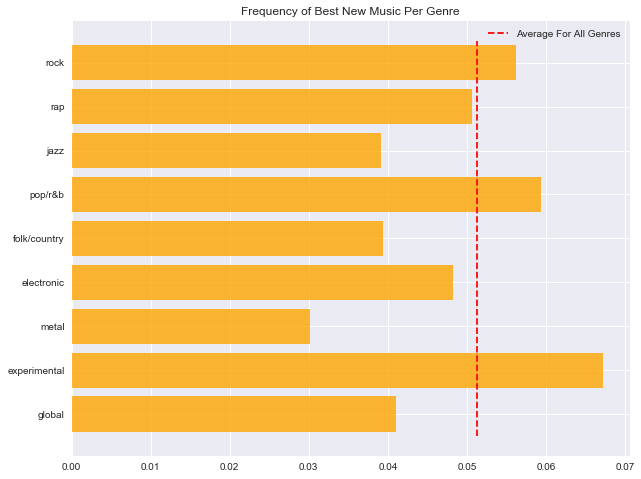

Global: 
     genre mean: 0.0411
  mu population: 0.05127

Experimental: 
     genre mean: 0.06722
  mu population: 0.05127

Metal: 
     genre mean: 0.03016
  mu population: 0.05127

Electronic: 
     genre mean: 0.04827
  mu population: 0.05127

Folk/Country: 
     genre mean: 0.03942
  mu population: 0.05127

Pop/R&B: 
     genre mean: 0.05936
  mu population: 0.05127

Jazz: 
     genre mean: 0.03908
  mu population: 0.05127

Rap: 
     genre mean: 0.05067
  mu population: 0.05127

Rock: 
     genre mean: 0.05616
  mu population: 0.05127



In [26]:
mean_bnms = [bnm_by_genre[genre].mean() for genre in genres]
plt.figure(figsize=(10,8))
plt.barh(genres, mean_bnms, alpha=0.8, color='orange')
plt.vlines(mu_bnm,-0.5,8.5, linestyles='dashed', 
           colors='red', label='Average For All Genres')
plt.legend()
plt.title('Frequency of Best New Music Per Genre')
plt.show()

for genre, mean in zip(genres, mean_bnms):
    print(f'{genre.title()}: \n'
        f'     genre mean: {round(mean, 5)}\n'
        f'  mu population: {round(mu_bnm, 5)}\n')

In [27]:
alpha = 0.1
bonferroni_alpha = alpha / len(genres)
bonferroni_alpha

0.011111111111111112

In [28]:
tests_by_genre = {}
for genre in bnm_by_genre:
    bnms = bnm_by_genre[genre]
    t_val, p_val = stats.ttest_1samp(bnms, mu_bnm)
    tests_by_genre[genre] = {
        't_val' : t_val,
        't_crit' : stats.t.ppf(1-bonferroni_alpha, len(bnms) -1),
        'p_val' : p_val,
    }
tests_by_genre

{'global': {'t_val': -0.7566877930227294,
  't_crit': 2.3029922469382376,
  'p_val': 0.45005391992707033},
 'experimental': {'t_val': 2.712667340358848,
  't_crit': 2.2885122631793666,
  'p_val': 0.006737474504092826},
 'metal': {'t_val': -3.6211575950131696,
  't_crit': 2.290690243733693,
  'p_val': 0.00031043031912163075},
 'electronic': {'t_val': -0.870763140434117,
  't_crit': 2.2874675746937077,
  'p_val': 0.3839374628045431},
 'folk/country': {'t_val': -1.593193149477528,
  't_crit': 2.2917644970463025,
  'p_val': 0.1115788415997883},
 'pop/r&b': {'t_val': 1.294829883663111,
  't_crit': 2.289038550669228,
  'p_val': 0.1955877965837994},
 'jazz': {'t_val': -1.3103617221416028,
  't_crit': 2.294779786135665,
  'p_val': 0.19076654702094978},
 'rap': {'t_val': -0.10725778282023768,
  't_crit': 2.288835335272128,
  'p_val': 0.9145982851368573},
 'rock': {'t_val': 2.0618796291729073,
  't_crit': 2.2869252842832197,
  'p_val': 0.03924651490612707}}

In [29]:
test_results_by_genre = {}
for genre in tests_by_genre:
    t_val = tests_by_genre[genre]['t_val']
    t_crit = tests_by_genre[genre]['t_crit']
    p_val = tests_by_genre[genre]['p_val']
    if t_val > t_crit and p_val < bonferroni_alpha:
        test_results_by_genre[genre] = f'Our findings indicate ' \
        f'that the alternative hypothesis is accepted with a p-val of {p_val}.'
    else: 
        test_results_by_genre[genre] = 'We fail to reject the null hypothesis.'

In [30]:
test_results_by_genre

{'global': 'We fail to reject the null hypothesis.',
 'experimental': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 0.006737474504092826.',
 'metal': 'We fail to reject the null hypothesis.',
 'electronic': 'We fail to reject the null hypothesis.',
 'folk/country': 'We fail to reject the null hypothesis.',
 'pop/r&b': 'We fail to reject the null hypothesis.',
 'jazz': 'We fail to reject the null hypothesis.',
 'rap': 'We fail to reject the null hypothesis.',
 'rock': 'We fail to reject the null hypothesis.'}

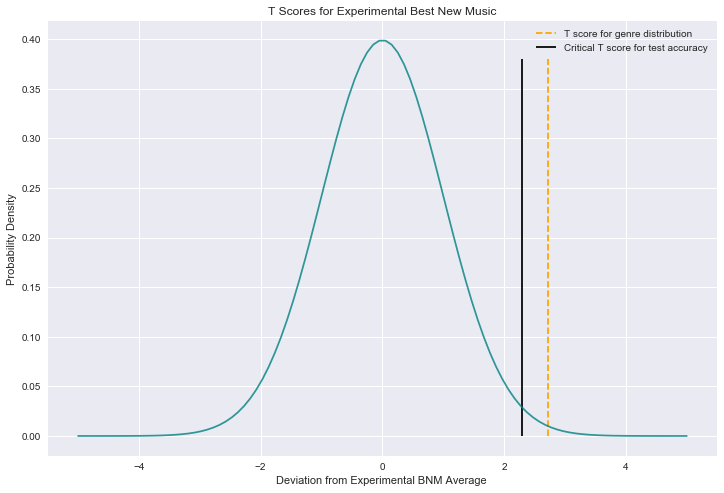

{'t_val': 2.712667340358848, 't_crit': 2.2885122631793666, 'p_val': 0.006737474504092826}


In [31]:
n = len(bnm_by_genre['experimental'])
df = n - 1
x = np.linspace(-5, 5, 100)
y = stats.t.pdf(x, df)

plt.figure(figsize=(12,8))
plt.plot(x,y, color='teal', alpha=0.8)

t = tests_by_genre['experimental']['t_val']
plt.vlines(t, 0, 0.38, linestyles='dashed', colors='orange', label='T score for genre distribution')

t_crit = tests_by_genre['experimental']['t_crit']
plt.vlines(t_crit, 0, 0.38, linestyles='-', colors='black', label='Critical T score for test accuracy')

plt.ylabel('Probability Density')
plt.xlabel('Deviation from Experimental BNM Average ')
plt.title('T Scores for Experimental Best New Music')
plt.legend()
plt.show()
print(tests_by_genre['experimental'])

In [32]:
# SPACE FOR NB EXP

In [33]:
# NEXT HYP ARE THERE MORE BNMS IN ANY OF THE TEN LARGEST LABELS???  3333333333333

In [34]:
# Find ten largest labels
query = """
    SELECT count(score), label, avg(best_new_music)
    FROM labels
    JOIN reviews
    USING(reviewid)
    GROUP BY label
    ORDER BY count(score) DESC
    LIMIT 10
    """
result = con.execute(query).fetchall()
top_labels = pd.DataFrame(result, columns=['number_of_reviews', 'label_name', 'avgerage_best_new_music'])
top_labels

,number_of_reviews,label_name,avgerage_best_new_music
0,420,self-released,0.03333333333333333333
1,272,drag city,0.04779411764705882353
2,268,sub pop,0.11940298507462686567
3,244,thrill jockey,0.00409836065573770492
4,239,merge,0.08368200836820083682
5,217,warp,0.10599078341013824885
6,211,domino,0.17061611374407582938
7,207,columbia,0.09661835748792270531
8,202,matador,0.11386138613861386139
9,168,warner bros.,0.04166666666666666667


In [35]:
for label in top_labels.label_name:
    print(label)

self-released
drag city
sub pop
thrill jockey
merge
warp
domino
columbia
matador
warner bros.


In [36]:
bnm_by_label = {}
for label in top_labels.label_name:
    query = f"""
    SELECT best_new_music
    FROM reviews
    JOIN labels
    USING (reviewid)
    WHERE label = '{label}'
    """
    result = con.execute(query).fetchall() 
    bnm_array =  np.array(result)[:,0]
    bnm_by_label[label]=bnm_array

In [37]:
# USING SAME MU BNM AND ALPHA  BUT OUR BONFERRONI CORRECTION CHANGES

In [38]:
print(mu_bnm, '  ', alpha)

0.05126950470287609    0.1


In [39]:
bonferroni_alpha = alpha / len(top_labels)
bonferroni_alpha

0.01

In [40]:
tests_by_label = {}
for label in bnm_by_label:
    bnms = bnm_by_label[label]
    t_val, p_val = stats.ttest_1samp(bnms, mu_bnm)
    tests_by_label[label] = {
        't_val' : t_val,
        't_crit' : stats.t.ppf(1-bonferroni_alpha, len(bnms) -1),
        'p_val' : p_val,
    }

In [41]:
test_results_by_label = {}
for label in tests_by_label:
    t_val = tests_by_label[label]['t_val']
    t_crit = tests_by_label[label]['t_crit']
    p_val = tests_by_label[label]['p_val']
    if np.abs(t_val) > np.abs(t_crit) and p_val < bonferroni_alpha:
        test_results_by_label[label] = f'Our findings indicate ' \
        f'that the alternative hypothesis is accepted with a p-val of {p_val}.'
    else: 
        test_results_by_label[label] = 'We fail to reject the null hypothesis.'

In [42]:
test_results_by_label

{'self-released': 'We fail to reject the null hypothesis.',
 'drag city': 'We fail to reject the null hypothesis.',
 'sub pop': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 0.0006908554616336897.',
 'thrill jockey': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 9.361615618190903e-25.',
 'merge': 'We fail to reject the null hypothesis.',
 'warp': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 0.009615855389874585.',
 'domino': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 7.376468407991896e-06.',
 'columbia': 'We fail to reject the null hypothesis.',
 'matador': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 0.005715176789920098.',
 'warner bros.': 'We fail to reject the null hypothesis.'}

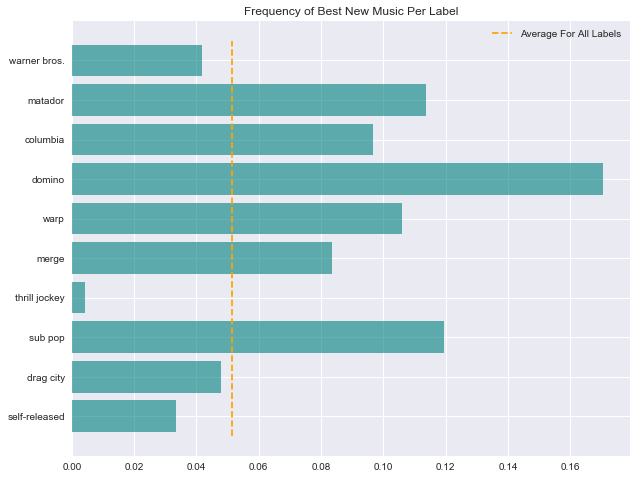

self-released: 
     label mean: 0.03333
  mu population: 0.05127

drag city: 
     label mean: 0.04779
  mu population: 0.05127

sub pop: 
     label mean: 0.1194
  mu population: 0.05127

thrill jockey: 
     label mean: 0.0041
  mu population: 0.05127

merge: 
     label mean: 0.08368
  mu population: 0.05127

warp: 
     label mean: 0.10599
  mu population: 0.05127

domino: 
     label mean: 0.17062
  mu population: 0.05127

columbia: 
     label mean: 0.09662
  mu population: 0.05127

matador: 
     label mean: 0.11386
  mu population: 0.05127

warner bros.: 
     label mean: 0.04167
  mu population: 0.05127



In [43]:
mean_bnms = [bnm_by_label[label].mean() for label in bnm_by_label]
plt.figure(figsize=(10,8))
plt.barh(top_labels.label_name, mean_bnms, alpha=0.6, color='teal')
plt.vlines(mu_bnm,-0.5,9.5, linestyles='dashed', 
           colors='orange', label='Average For All Labels')
plt.title('Frequency of Best New Music Per Label')
plt.legend()
plt.show()
for label, mean in zip(top_labels.label_name, mean_bnms):
    print(f'{label}: \n'
        f'     label mean: {round(mean, 5)}\n'
        f'  mu population: {round(mu_bnm, 5)}\n')

In [44]:
# NOTEBOOK EXP

In [45]:
# HYP 4 HERE WE GOOOOOOOOO Is there a harsher reviewer??
#                                                    4444444444444444444 

In [46]:
# Find average number of reviews for per reviewer
query = """
    SELECT count(score), author
    FROM reviews
    GROUP BY author
    """
result = con.execute(query).fetchall()
result[:4]

[(2, 'jesse fahnestock'),
 (1, 'edwin stats houghton'),
 (1, 'the pitchfork staff'),
 (62, 'kim kelly')]

In [47]:
num_reviews = [tup[0] for tup in result]
num_reviews[:4]

[2, 1, 1, 62]

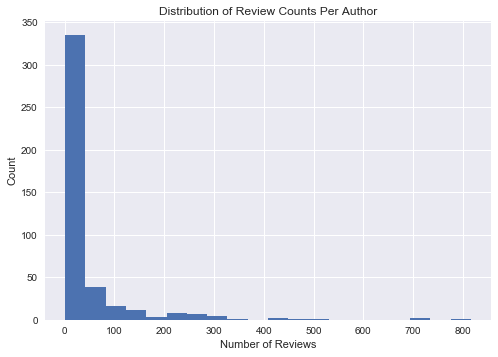

In [48]:
plt.hist(num_reviews,bins=20)
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('Distribution of Review Counts Per Author');

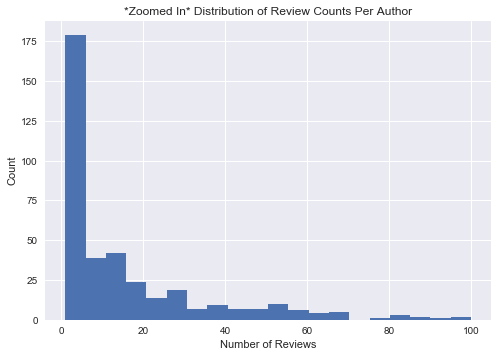

In [62]:
# There are a lot of counts for authors with less reviews.
    # Zoom in to the authors with less reviews to analyze 
    # the distibution for the bulk of the data
plt.hist(num_reviews, bins=20, range=(1,100))
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('*Zoomed In* Distribution of Review Counts Per Author');

In [50]:
print('Average Number of Reviews Per Author is:')
print('    ',  np.mean(num_reviews))

Average Number of Reviews Per Author is:
     42.576388888888886


In [51]:
# Which of the authors with more reviews than average 
    # are giving the lowest scores???
query = """
    SELECT author, avg(score), count(score)
    FROM reviews
    GROUP BY author
    HAVING count(score) > 42.5
    ORDER BY avg(score)
    LIMIT 10
    """
result = con.execute(query).fetchall()
pd.DataFrame(result, columns=['author', 'avg_score', 'num_reviews'])

,author,avg_score,num_reviews
0,alison fields,5.810870,46
1,adam moerder,6.151675,209
2,brent dicrescenzo,6.163441,93
3,joshua love,6.342056,107
4,liz colville,6.343396,53
5,ian cohen,6.353934,699
6,rob mitchum,6.392884,267
7,jordan sargent,6.486441,59
8,cory d. byrom,6.507937,63
9,evan rytlewski,6.515094,53


In [52]:
# Retrieve Alison Fields' Distribution
query = """
    SELECT score
    FROM reviews
    WHERE author = 'alison fields'
    """
result = con.execute(query).fetchall()
alison_scores = np.array(result)[:,0]

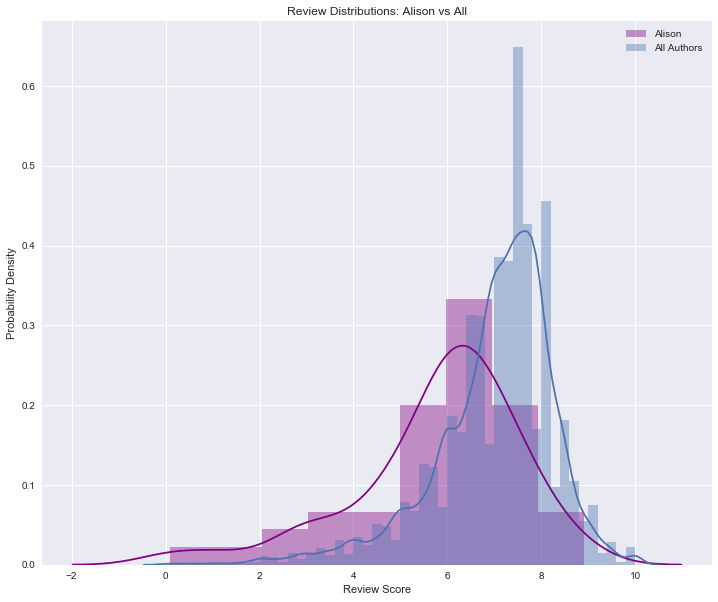

In [53]:
plt.figure(figsize=(12,10))
sns.distplot(alison_scores, color='purple', label='Alison')
sns.distplot(scores_all_labels, label='All Authors')
plt.ylabel('Probability Density')
plt.xlabel('Review Score')
plt.legend()
plt.title('Review Distributions: Alison vs All');

In [54]:
# Alpha is set high to detect the slightest chance of a harsher critic
alpha = 0.2

t_val, p_val = stats.ttest_1samp(alison_scores, mu_review_score)

df = len(alison_scores)-1
t_crit = stats.t.ppf(alpha, df)

print(f"""
    t_val: {t_val}
    t_crit: {t_crit}
    p_val: {p_val}
    alpha: {alpha}
    """)


    t_val: -4.535080661412207
    t_crit: -0.8496819044581843
    p_val: 4.2481512426639494e-05
    alpha: 0.2
    


In [55]:
t_val < t_crit  # ONE TAILED TEST IF LOWER

True

In [56]:
p_val < alpha

True

<div>The t score is outside the critical t for the distribution of all scores.</div>
<div>Our findings on the average score of self released is different enough </div>
<div>from the distribution of all scores and there fore statictically significant.</div>
<div>-- </div>
<div>Our p_value is adequately smaller than at our alpha significance.</div>
<div>There is a 20 percent chance our results were generated by randomness</div>

In [57]:
# HYP 5   5555555      55555555

In [58]:
# Find artists with best reviews for first decade 
    # that ALSO had an album reviewed recently
query = """
    SELECT artist
    FROM reviews 
    WHERE artist in (SELECT artist FROM reviews where pub_date > '2014-01-01') 
    AND pub_date < '2010-01-01' 
    GROUP BY artist
    ORDER BY avg(score) DESC
    LIMIT 20
    """
result = con.execute(query).fetchall()
artists = [tup[0] for tup in result]
artists

['john coltrane',
 'the avalanches',
 'sly and the family stone',
 'the velvet underground',
 'pavement',
 'loretta lynn',
 'jawbox',
 'albert ayler',
 'the feelies',
 'gas',
 'blur',
 'otis redding',
 'elvis presley',
 'this heat',
 'panda bear',
 'rhys chatham',
 'red red meat',
 'nachtmystium',
 'betty davis',
 'ennio morricone']

In [59]:
# Find average score for recent reviews
query = """
    SELECT score
    FROM reviews
    WHERE pub_date > '2014-01-01'
    """
result = con.execute(query).fetchall()
modern_mu = np.mean(result)
modern_mu

7.149119865884324

In [60]:
# Find scores of artists for modern releases
artist_modern_scores = {}
for artist in artists:
    query = f"""
    SELECT score
    FROM reviews
    WHERE pub_date > '2014-01-01'
    AND artist = '{artist}'
    """
    result = con.execute(query).fetchall()
    scores = [tup[0] for tup in result]
    artist_modern_scores[artist] = scores
artist_modern_scores

{'john coltrane': [10.0, 8.5],
 'the avalanches': [8.5],
 'sly and the family stone': [7.9],
 'the velvet underground': [8.5, 10.0, 10.0, 10.0],
 'pavement': [7.0],
 'loretta lynn': [8.0],
 'jawbox': [7.6],
 'albert ayler': [8.4],
 'the feelies': [7.9],
 'gas': [9.5],
 'blur': [7.0],
 'otis redding': [9.0],
 'elvis presley': [7.0],
 'this heat': [9.0],
 'panda bear': [7.1, 8.7],
 'rhys chatham': [7.6],
 'red red meat': [8.0],
 'nachtmystium': [3.9],
 'betty davis': [6.8],
 'ennio morricone': [8.0]}

In [61]:
# UH OHH THESE SAMPLES ARE TOO SMALL